# Exploratory Analysis of BSS State and Trends

This notebook will provide the initial exploration and orientation with the BSS, and outputs may feature in the report. 

Note, at the time of writing the latest record is 2020-04-12 23:59

In [32]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import getcwd, chdir

In [33]:
# work from the project root
if getcwd()[-9:] == 'notebooks':
    chdir("..")

In [34]:
# connect to sqlite database
DBPATH = "data/bike_db.db"
db = sqlite3.connect(DBPATH)

## Explore monthly journey volumes

In [35]:
# Select Monthly-aggregated journey data
query = """
    SELECT
        year
        ,month
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year >= 2012
    GROUP BY 1,2
    ORDER BY 1,2
"""

mth_df = pd.read_sql_query(query, db)

In [36]:
# Merge year and month col into a proper datetime index
mth_df = mth_df.set_index(pd.to_datetime(mth_df[['year','month']].assign(day=1)))

In [37]:
def journey_plot(df, title='journeys', ylab='journeys'):
    ax = df.journeys.plot(
        figsize=(10,5)
        ,title=title
        ,grid=True);
    ax.set_ylabel(ylab);
    ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);

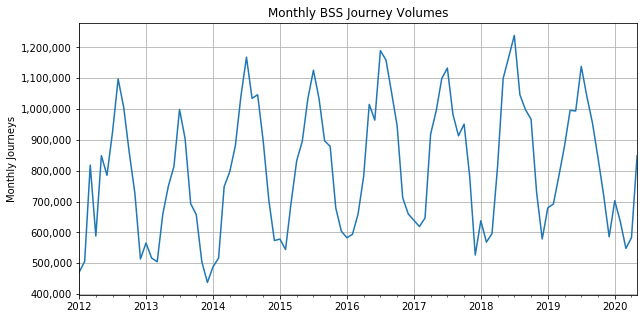

In [38]:
journey_plot(mth_df, 'Monthly BSS Journey Volumes', 'Monthly Journeys')

## Inspect 2020 at the daily level

In [39]:
# This fetches minute-ly data which we'll down-sample
df_20 = pd.read_sql_query("""
    SELECT
        "Start Date" AS start_date
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2020
    GROUP BY 1
    """, db)

In [61]:
df_20['start_date'] = pd.to_datetime(df_20.start_date)
df_20.set_index('start_date', inplace=True)

AttributeError: 'DataFrame' object has no attribute 'start_date'

I'm also fetching 2019 as a year-on-year comparison point

In [60]:
# This fetches minute-ly data which we'll down-sample
df_19 = pd.read_sql_query("""
    SELECT
        "Start Date" AS start_date
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2019
        AND month <= 5
        AND "Start Date" <= "2019-05-26"
    GROUP BY 1
    """, db)

In [62]:
df_19['start_date'] = pd.to_datetime(df_19.start_date)
_ = df_19.copy()
df_19.set_index('start_date', inplace=True)

In [68]:
# My hacky way of overlaying 2019 with 2020
_['start_date'] = _['start_date'].apply(lambda x: x + pd.DateOffset(years=1))
_.set_index('start_date', inplace=True)

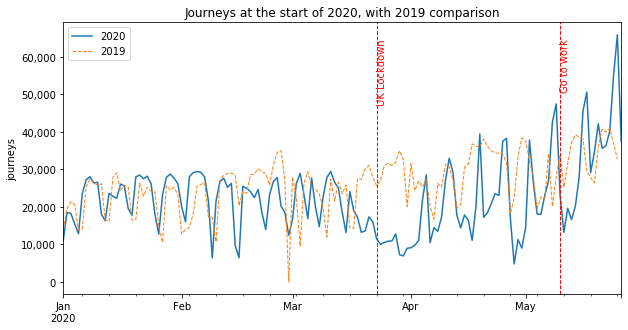

In [83]:
ax = df_20.resample('D').sum().plot(label='2020', figsize=(10,5)
                                   ,title='Journeys at the start of 2020, with 2019 comparison');
_.resample('D').sum().plot(ax = ax, label='2019', lw=1, linestyle='--');

ax.axvline(pd.to_datetime('2020-03-23'), color='r', linestyle='--', lw=1)
plt.text(pd.to_datetime('2020-03-23'),65000,'UK Lockdown',rotation=90, color='r', verticalalignment='top')

ax.axvline(pd.to_datetime('2020-05-10'), color='r', linestyle='--', lw=1)
plt.text(pd.to_datetime('2020-05-10'),65000,'Go to work',rotation=90, color='r', verticalalignment='top')

plt.legend(['2020','2019']);
ax.set_ylabel('journeys');
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
ax.set_xlabel(None);

Up next:
* Show a normalised week / day at the network level
* Prepare station load date